# Elliptical Slice Sampling
The purpose of this notebook is to check if the `elliptic.py` file implementing Elliptical Slice Sampling works as expected, whilst demonstrating how it can be used to sample from the latent variable posterior $p(\mathbf{f} | \mathbf{y}, \boldsymbol{\theta})$.

In [4]:
import numpy as np

from matplotlib import pyplot as plt

from gproc.elliptic_cpp import ess_samples_probit_cpp
from gproc.generative import sample_at_x
from gproc.kernels import *
from gproc.kernels import rational_quadratic
from gproc.kernels import periodic

## Data Generation

In [5]:
N = 500 # Data size
D = 1 # Data dimension

x = np.random.uniform(-1, 1, N * D).reshape(-1, D) # Reshape to N x D matrix
true_lengthscale = 1
true_variance = 1
kernel = SquaredExponential(lengthscale = true_lengthscale, variance = true_variance)

y, prob_y, f = sample_at_x(x, kernel)
y = y.astype("float64")

## Generate Latent Posterior Samples

In [6]:
K = kernel.make_gram(x, x)

K_chol = np.linalg.cholesky(K + 0.0001*np.eye(K.shape[0]))
samples = ess_samples_probit_cpp(K_chol, y, 2500, 500, verbose=True)

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:15<00:00, 39.88it/s]


## Mean of Samples Against True Function and Laplace

### ESS Samples Mean

In [7]:
ess_mean = np.mean(samples, axis=0)

In [8]:
samples

array([[ 0.40273115,  0.36091473,  0.15230595, ...,  0.17447724,
        -0.01553767,  0.33753762],
       [ 0.34972271,  0.29545412,  0.03060087, ...,  0.13706236,
        -0.11785116,  0.29633928],
       [ 0.3009436 ,  0.25469974,  0.00525492, ...,  0.08209071,
        -0.1417038 ,  0.23957235],
       ...,
       [ 0.39930841,  0.31801137, -0.10521238, ...,  0.32658855,
        -0.4560505 ,  0.41417301],
       [ 0.44630559,  0.40320603,  0.04327993, ...,  0.27156071,
        -0.29793618,  0.40235194],
       [ 0.41243354,  0.36210421, -0.02515921, ...,  0.28634077,
        -0.3861206 ,  0.39101003]])

### Laplace Approximation

In [9]:
from gproc.laplace import laplace_approximation_probit, chol_inverse

inverse_gram, _ = chol_inverse(K)
laplace_mean, df_ll, laplace_cov, objective_history, converged = laplace_approximation_probit(y, inverse_gram)

In [10]:
laplace_samples = np.random.multivariate_normal(laplace_mean, laplace_cov, 2500)

## Plot Means

In [11]:
ess_mean.shape

(500,)

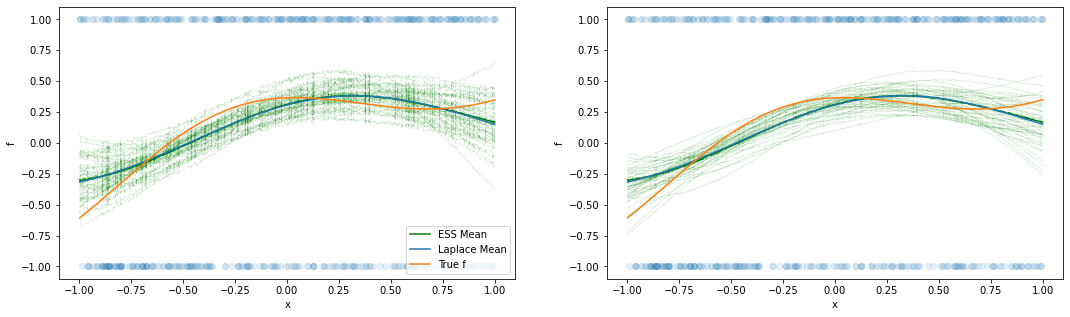

In [13]:
sort_ix = np.argsort(x.reshape(-1))

fig, axarr = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [1,1]})

axarr[0].scatter(x, y, alpha=0.1)
axarr[0].set_xlabel('x')
axarr[0].set_ylabel('f')

for i in range(0, samples.shape[0], 50):
    axarr[0].plot(x[sort_ix], samples[i, sort_ix], c = 'g', linewidth = 0.1)

axarr[0].plot(x[sort_ix], ess_mean[sort_ix], c='g', label='ESS Mean')
axarr[0].plot(x[sort_ix], laplace_mean[sort_ix], label='Laplace Mean')
axarr[0].plot(x[sort_ix], f[sort_ix], label='True f')

axarr[0].legend()

axarr[1].scatter(x, y, alpha=0.1)
axarr[1].set_xlabel('x')
axarr[1].set_ylabel('f')

for i in range(0, laplace_samples.shape[0], 50):
    axarr[1].plot(x[sort_ix], laplace_samples[i, sort_ix], c = 'g', linewidth = 0.1)

axarr[1].plot(x[sort_ix], ess_mean[sort_ix], c='g', label='ESS Mean')
axarr[1].plot(x[sort_ix], laplace_mean[sort_ix], label='Laplace Mean')
axarr[1].plot(x[sort_ix], f[sort_ix], label='True f')
axarr[0].legend()

plt.show()

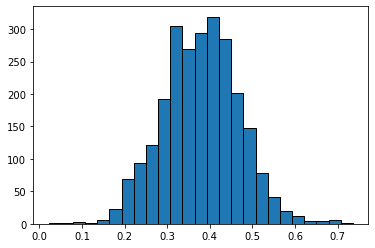

In [18]:
plt.hist(samples[:,0], bins=25, ec = 'black')
plt.show()